In [1]:
from datetime import datetime, timedelta, timezone
from dateutil.tz import tzutc
from dateutil.relativedelta import relativedelta
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from scipy.stats import pearsonr, mode, skew, kurtosis
from scipy.signal import savgol_filter
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_squared_error, plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import mean_squared_error as MSE


addDataPrefix = "/Users/sorush/My Drive/Documents/Educational/TAMU/Research/Trial/Data/11-5-21-11-15-21"
if not os.path.exists(addDataPrefix):
    addDataPrefix = "/home/grads/s/sorush.omidvar/CGMDataset/Trial/Data/11-5-21-11-15-21"
if not os.path.exists(addDataPrefix):
    addDataPrefix = "C:\\GDrive\\Documents\\Educational\\TAMU\\Research\\Trial\\Data\\11-5-21-11-15-21"

addUserInput = os.path.join(addDataPrefix, "User inputted")
addHKCM = os.path.join(addDataPrefix, "hk+cm")
addCGM = os.path.join(addDataPrefix, "CGM")
addE4 = os.path.join(addDataPrefix, "E4")

exempts = ["p2"]

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({"figure.facecolor": "white"})
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # no GPU

import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)


In [2]:
START_OF_TRIAL = datetime.strptime("11 06 2021-02:00:00", "%m %d %Y-%H:%M:%S")  # to handle the daylight saving issue in apple watches
END_OF_TRIAL = datetime.strptime("11 15 2021-00:00:00", "%m %d %Y-%H:%M:%S")

if os.path.exists(os.path.join(addDataPrefix, "Results", "All_meals.pkl")):
    os.remove(os.path.join(addDataPrefix, "Results", "All_meals.pkl"))
os.chdir(addUserInput)
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_meals.pkl")):
    dfMeal = []
    for root, dirs, files in os.walk(addUserInput):
        for file in files:
            if ".xlsx" in file.lower():
                if "meals-modified" in file.lower():
                    participantName = file[: file.find("Meals")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_excel(file)
                    dfTemp.insert(0, "Participant", participantName)
                    dfTemp.drop(columns=["startTime", "FinishTime", "Duration"], inplace=True)
                    dfTemp.rename(columns={"startTimeModified": "StartTime"}, inplace=True)
                    dfTemp.rename(columns={"FinishTimeModified": "FinishTime"}, inplace=True)
                    dfTemp["StartTime"] = pd.to_datetime(dfTemp["StartTime"])
                    dfTemp["FinishTime"] = pd.to_datetime(dfTemp["FinishTime"])
                    dfTemp = dfTemp[dfTemp["StartTime"].notna()]
                    # dfTemp['StartTime']-=pd.DateOffset(hours=5)#fixing the time zone issue
                    # dfTemp['FinishTime']-=pd.DateOffset(hours=5)#fixing the time zone issue
                    dfTemp.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
                    dfTemp.reset_index(drop=True, inplace=True)
                    for counter in range(1, len(dfTemp)):
                        if dfTemp["StartTime"].iloc[counter] == dfTemp["StartTime"].iloc[counter - 1]:
                            dfTemp["Carbs"].iloc[counter] += dfTemp["Carbs"].iloc[counter - 1]
                            dfTemp["Fat"].iloc[counter] += dfTemp["Fat"].iloc[counter - 1]
                            dfTemp["Protein"].iloc[counter] += dfTemp["Protein"].iloc[counter - 1]
                            dfTemp["StartTime"].iloc[counter] = ""
                    dfTemp = dfTemp[dfTemp["StartTime"].notna()]
                    dfTemp.reset_index(drop=True, inplace=True)
                    for counter in range(1, len(dfTemp)):
                        if dfTemp["StartTime"].iloc[counter] - dfTemp["StartTime"].iloc[counter - 1] <= timedelta(hours=1):
                            print("The meals are not compressed for participant:", participantName, dfTemp["StartTime"].iloc[counter], dfTemp["StartTime"].iloc[counter - 1])
                            print(dfTemp)
                            os._exit()
                    if len(dfMeal) != 0:
                        frames = [dfTemp, dfMeal]
                        dfMeal = pd.concat(frames)
                    else:
                        dfMeal = dfTemp
    print("reading is done")
    dfMeal = dfMeal[dfMeal["StartTime"] >= START_OF_TRIAL]
    dfMeal = dfMeal[dfMeal["FinishTime"] < END_OF_TRIAL]
    dfMeal.reset_index(drop=True, inplace=True)
    print("Meal database is limited to the trial period")
    dfMeal.to_pickle(os.path.join(addDataPrefix, "Results", "All_meals.pkl"))
else:
    dfMeal = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_meals.pkl"))


def pdInterpolation(dfTemp):
    index = dfTemp["Time"]
    seriesParticipant = pd.Series(dfTemp["Abbot"].to_list(), index=index)
    seriesParticipant = seriesParticipant.resample("1T").asfreq()
    seriesParticipant.interpolate(method="polynomial", order=3, inplace=True)
    tempTime = seriesParticipant.index
    tempVal = seriesParticipant.values
    dfTemp = pd.DataFrame(zip(tempTime, tempVal), columns=["Time", "Abbot"])
    return dfTemp


# if os.path.exists(os.path.join(addDataPrefix,"Results",'All_cgm.pkl')):
#     os.remove(os.path.join(addDataPrefix,"Results",'All_cgm.pkl'))
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_cgm.pkl")):
    os.chdir(addCGM)
    dfCGM = []
    for root, dirs, files in os.walk(addCGM):
        for file in files:
            if ".txt" in file.lower():
                if "_fl" in file.lower():
                    participantName = file[: file.find("_fl")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file, sep="\t", skiprows=1)
                    if len(dfTemp.columns) != 4:
                        print("MAYDAY. Error in reading csv")
                        break
                    dfTemp.columns.values[0] = "ID"
                    dfTemp.columns.values[1] = "Time"
                    dfTemp.columns.values[2] = "Record"
                    dfTemp.columns.values[3] = "Abbot"
                    dfTemp.drop(columns=["ID", "Record"], inplace=True)
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"])
                    dfTemp["Abbot"] = pd.to_numeric(dfTemp["Abbot"])
                    dfTemp.sort_values(["Time"], ascending=(True), inplace=True)
                    dfTemp = pdInterpolation(dfTemp)
                    dfTemp.insert(0, "Participant", participantName)
                    if len(dfTemp.columns) != 3:
                        print("MAYDAY. Error in processing csv")
                        break
                    if len(dfCGM) != 0:
                        frames = [dfTemp, dfCGM]
                        dfCGM = pd.concat(frames)
                    else:
                        dfCGM = dfTemp
    print("reading is done")
    dfCGM = dfCGM[dfCGM["Time"] >= START_OF_TRIAL]
    dfCGM = dfCGM[dfCGM["Time"] < END_OF_TRIAL]
    print("CGM database is limited to the trial period")
    dfCGM.to_pickle(os.path.join(addDataPrefix, "Results", "All_cgm.pkl"))
else:
    dfCGM = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_cgm.pkl"))


# if os.path.exists(os.path.join(addDataPrefix,"Results",'All_cm.pkl')):
#     os.remove(os.path.join(addDataPrefix,"Results",'All_cm.pkl'))
os.chdir(addHKCM)
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_cm.pkl")):
    df = []
    for root, dirs, files in os.walk(addHKCM):
        for file in files:
            if ".csv" in file.lower():
                if "cm" in file.lower() and "modified" in file.lower():
                    participantName = file[: file.find("_cm")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file)
                    print("File is read")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"])
                    dfTemp.insert(0, "Participant", participantName)
                    dfTemp.insert(len(dfTemp.columns), "|Ax|+|Ay|+|Az|", dfTemp["Ax"].abs() + dfTemp["Ay"].abs() + dfTemp["Az"].abs() + 0.001)  # this is to avoid 0 later on for feature calculation
                    dfTemp.insert(len(dfTemp.columns), "|Yaw|+|Roll|+|Pitch|", dfTemp["Yaw"].abs() + dfTemp["Roll"].abs() + dfTemp["Pitch"].abs())
                    dfTemp.insert(len(dfTemp.columns), "RotationalToLinear", dfTemp["|Yaw|+|Roll|+|Pitch|"] / dfTemp["|Ax|+|Ay|+|Az|"])
                    print("modified")
                    dfTemp.sort_values(["Time"], ascending=(True), inplace=True)
                    print("sorted")
                    if len(dfTemp.columns) != 14:
                        print("MAYDAY. Error in reading csv")
                        print(dfTemp.columns)
                        break
                    if len(df) != 0:
                        frames = [dfTemp, df]
                        df = pd.concat(frames)
                    else:
                        df = dfTemp
    dfCM = df
    print("Processing is done")
    dfCM = dfCM[dfCM["Time"] >= START_OF_TRIAL]
    dfCM = dfCM[dfCM["Time"] < END_OF_TRIAL]
    print("CM database is limited to the trial period")
    dfCM.to_pickle(os.path.join(addDataPrefix, "Results", "All_cm.pkl"))
else:
    dfCM = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_cm.pkl"))


# if os.path.exists(os.path.join(addDataPrefix, "Results",'All_E4.pkl')):
#     os.remove(os.path.join(addDataPrefix, "Results",'All_E4.pkl'))
os.chdir(addE4)
# fields=['ACC','BVP','EDA','HR','IBI','TEMP']
fields = ["BVP", "EDA", "HR", "TEMP"]
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_E4.pkl")):
    dfE4 = []
    for root, dirs, files in os.walk(addE4):
        for file in files:
            if ".csv" in file.lower():
                participantName = root[root.find("E4") + 3 :]
                participantName = participantName[:2]
                field = file[: file.find(".csv")]
                if field not in fields:
                    print("File name does not comply with analyzed fields", file)
                    continue
                print(participantName, field)
                if participantName in exempts:
                    print("Exemption...", file)
                    continue
                print("Reading ...", file)
                os.chdir(root)
                dfTemp = pd.read_csv(file, header=None)
                # if field=='ACC':
                #     assert len(dfTemp.columns)==3
                #     timeBase=dfTemp.iloc[0,0]
                #     timeStep=1/dfTemp.iloc[1,0]
                #     dfTemp.drop([0,1],inplace=True)
                #     dfTemp.rename(columns={0:'Data1',1:'Data2',2:'Data3'}, inplace=True)#x,y,z for data1,data2,data3
                #     timeTemp=[]
                #     for counter in range(len(dfTemp)):
                #         timeTemp.append(timeBase+counter*timeStep)
                #     dfTemp.insert(0,'Time',timeTemp)
                #     dfTemp.insert(0,'Field',"Acceleration")
                #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                if field == "BVP":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "BVP")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                elif field == "HR":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "HR")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                elif field == "EDA":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "EDA")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                # elif field=='IBI':
                #     assert len(dfTemp.columns)==2
                #     timeBase=dfTemp.iloc[0,0]
                #     dfTemp.drop([0],inplace=True)
                #     dfTemp.rename(columns={0:'Time',1:'Data1'}, inplace=True)
                #     dfTemp["Data2"]=""
                #     dfTemp["Data3"]=""
                #     timeTemp=[]
                #     dfTemp['Time']+=timeBase
                #     dfTemp.insert(0,'Field',"IBI")
                #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                elif field == "TEMP":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "Temperature")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                dfTemp.insert(0, "Participant", participantName)

                dfTemp["Time"] -= pd.DateOffset(hours=6)  # Empatica records in GMT and also during the trial we had daylight saving
                dfTemp.sort_values(["Participant", "Field", "Time"], ascending=(True, True, True), inplace=True)
                if len(dfTemp.columns) != 6:
                    print("MAYDAY. Error in reading csv")
                    break
                if len(dfE4) != 0:
                    frames = [dfTemp, dfE4]
                    dfE4 = pd.concat(frames)
                else:
                    dfE4 = dfTemp

    print("reading is done")
    dfE4 = dfE4[dfE4["Time"] >= START_OF_TRIAL]
    dfE4 = dfE4[dfE4["Time"] < END_OF_TRIAL]
    print("E4 database is limited to the trial period")
    dfE4.to_pickle(os.path.join(addDataPrefix, "Results", "All_E4.pkl"))
else:
    dfE4 = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_E4.pkl"))


Reading ... p3Meals-Modified.xlsx
Reading ... p4Meals-Modified.xlsx
Reading ... p1Meals-Modified.xlsx
reading is done
Meal database is limited to the trial period
File name does not comply with analyzed fields FinalReport.csv
File name does not comply with analyzed fields mamad.csv
File name does not comply with analyzed fields tags.csv
File name does not comply with analyzed fields IBI.csv
p4 TEMP
Reading ... TEMP.csv
p4 HR
Reading ... HR.csv
p4 BVP
Reading ... BVP.csv


In [ ]:
OUTTER_WINDOW_LENGTH = timedelta(minutes=60)
OUTTER_WINDOW_STEP = timedelta(minutes=60)
INNER_WINDOW_LENGTH = timedelta(minutes=1)
COMPLEX_MEAL_LENGTH = timedelta(minutes=180)
FASTING_LENGTH = timedelta(hours=3)
MINIMUM_POINT = INNER_WINDOW_LENGTH.total_seconds()


def e4Reporter(df):
    topics = ["BVP", "EDA", "HR", "Temperature"]
    report = []
    for topic in topics:
        dfTemp = df[df["Field"] == topic]
        if topic == "BVP":
            MIN_POINT = MINIMUM_POINT * 64 * 0.3
        elif topic == "EDA":
            MIN_POINT = MINIMUM_POINT * 4 * 0.3
        elif topic == "HR":
            MIN_POINT = MINIMUM_POINT / 10 * 0.3
        elif topic == "Temperature":
            MIN_POINT = MINIMUM_POINT * 4 * 0.3
        else:
            print("MAYDAY at sensor reader")
            os._exit()
        if len(dfTemp) < MIN_POINT:
            report.append("Nan")
        else:
            val = dfTemp["Data1"].mean()
            report.append(val)
    return report


def motionCalculator(df):
    f1 = df["RotationalToLinear"].mean()
    f2 = df["|Ax|+|Ay|+|Az|"].mean()
    f5 = df["|Yaw|+|Roll|+|Pitch|"].mean()
    return [f1, f2, f5]


def statFeatures(dataList):
    dataList = np.asarray(dataList).astype(float)
    result = []
    dataDim = dataList.ndim
    if dataDim > 1:
        for counter in range(dataList.shape[1]):
            if not np.isnan(dataList[:, counter]).all():
                meanVal = np.nanmean(dataList[:, counter], axis=0)
                stdVal = np.nanstd(dataList[:, counter], axis=0)
                minVal = np.nanmin(dataList[:, counter], axis=0)
                maxVal = np.nanmax(dataList[:, counter], axis=0)
                rangeVal = maxVal - minVal
                skewnessVal = skew(dataList[:, counter], nan_policy="omit", axis=0)
                kurtosisVal = kurtosis(dataList[:, counter], nan_policy="omit", axis=0)
                result.extend([rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal])
            else:
                result.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    else:
        if not np.isnan(dataList).all():
            meanVal = np.nanmean(dataList)
            stdVal = np.nanstd(dataList)
            minVal = np.nanmin(dataList)
            maxVal = np.nanmax(dataList)
            rangeVal = maxVal - minVal
            skewnessVal = skew(dataList, nan_policy="omit")
            kurtosisVal = kurtosis(dataList, nan_policy="omit")
            result.extend([rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal])
        else:
            result.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    return result


def innerWindowExtractor(outterWindowStart, innerWindowNumber, dfParticipantCM, dfParticipantE4):
    tempListCM = []
    tempListE4 = []
    for counterInner in range(0, innerWindowNumber, 1):
        innerWindowStart = outterWindowStart + counterInner * INNER_WINDOW_LENGTH
        innerWindowEnd = innerWindowStart + INNER_WINDOW_LENGTH
        dfTempCM = dfParticipantCM[(dfParticipantCM["Time"] >= innerWindowStart) & (dfParticipantCM["Time"] < innerWindowEnd)]

        if len(dfTempCM) < MINIMUM_POINT * 10 * 0.3:
            tempListCM.append(["Nan", "Nan", "Nan"])
        else:
            tempListCM.append(motionCalculator(dfTempCM))

        dfTempE4 = dfParticipantE4[(dfParticipantE4["Time"] >= innerWindowStart) & (dfParticipantE4["Time"] < innerWindowEnd)]
        if len(dfTempE4) < MINIMUM_POINT * 32 * 0.3:
            tempListE4.append(["Nan", "Nan", "Nan", "Nan"])
        else:
            tempListE4.append(e4Reporter(dfTempE4))

    return tempListCM, tempListE4


def outterPosWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant):
    print("Positive windows:")
    participantDataList = []
    for counterOuter in tqdm(range(0, len(dfParticipantMeal))):
        outterWindowStart = dfParticipantMeal["StartTime"].iloc[counterOuter]
        outterWindowEnd = outterWindowStart + OUTTER_WINDOW_LENGTH
        innerWindowNumber = int(OUTTER_WINDOW_LENGTH.total_seconds() / INNER_WINDOW_LENGTH.total_seconds())
        tempListInfo = [outterWindowStart, outterWindowEnd, participant]
        tempList = []
        tempListCM, tempListE4 = innerWindowExtractor(outterWindowStart, innerWindowNumber, dfParticipantCM, dfParticipantE4)

        carbs = dfParticipantMeal["Carbs"].iloc[counterOuter]
        protein = dfParticipantMeal["Protein"].iloc[counterOuter]
        fat = dfParticipantMeal["Fat"].iloc[counterOuter]

        tempListCM = statFeatures(tempListCM)
        tempList.extend(tempListCM)  # 7*3=21

        tempListE4 = statFeatures(tempListE4)
        tempList.extend(tempListE4)  # 7*4=28

        dfTempCGM = dfParticipantCGM[(dfParticipantCGM["Time"] >= outterWindowStart) & (dfParticipantCGM["Time"] < outterWindowEnd)]
        tempListCGM = dfTempCGM["Abbot"].to_list()
        tempListCGM = statFeatures(tempListCGM)
        tempList.extend(tempListCGM)  # 7
        tempList.extend(tempListInfo)  # 3
        tempList.append(carbs)
        tempList.append(fat)
        tempList.append(protein)
        tempList.append(1)  # mealFlag
        assert len(tempList) == 7 * 3 + 7 * 4 + 7 + 3 + 4
        participantDataList.append(tempList)
    return participantDataList


def outterNegWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant):
    print("Negative windows:")
    participantDataList = []
    gaps = []

    for counterOuter in range(1, len(dfParticipantMeal)):
        if dfParticipantMeal["StartTime"].iloc[counterOuter] - dfParticipantMeal["StartTime"].iloc[counterOuter - 1] >= FASTING_LENGTH:
            gaps.append([dfParticipantMeal["StartTime"].iloc[counterOuter - 1], dfParticipantMeal["StartTime"].iloc[counterOuter]])

    for counterOuter in tqdm(range(len(gaps))):
        querryTemp = gaps[counterOuter]
        querryStart = querryTemp[0] + FASTING_LENGTH
        querryEnd = querryTemp[1]
        querryWindNum = datetime.timestamp(querryEnd) - datetime.timestamp(querryStart)
        querryWindNum = int(querryWindNum / OUTTER_WINDOW_LENGTH.total_seconds())

        for counter in range(querryWindNum):
            outterWindowStart = querryStart + counter * OUTTER_WINDOW_LENGTH
            outterWindowEnd = outterWindowStart + OUTTER_WINDOW_LENGTH

            dfTempE4 = dfParticipantE4[dfParticipantE4["Time"] >= outterWindowStart]
            dfTempE4 = dfTempE4[dfTempE4["Time"] < outterWindowEnd]
            if len(dfTempE4) < OUTTER_WINDOW_LENGTH.total_seconds() * (64 + 4 + 4) * 0.3:
                print("Not enough data for E4", outterWindowStart, outterWindowEnd)
                continue

            dfTempCM = dfParticipantCM[dfParticipantCM["Time"] >= outterWindowStart]
            dfTempCM = dfTempCM[dfTempCM["Time"] < outterWindowEnd]
            if len(dfTempCM) < OUTTER_WINDOW_LENGTH.total_seconds() * 10 * 0.3:
                print("Not enough data for Apple", outterWindowStart, outterWindowEnd)
                continue

            innerWindowNumber = int(OUTTER_WINDOW_LENGTH.total_seconds() / INNER_WINDOW_LENGTH.total_seconds())
            tempListInfo = [outterWindowStart, outterWindowEnd, participant]
            tempList = []
            tempListCM, tempListE4 = innerWindowExtractor(outterWindowStart, innerWindowNumber, dfParticipantCM, dfParticipantE4)

            carbs = 0
            protein = 0
            fat = 0

            tempListCM = statFeatures(tempListCM)
            tempList.extend(tempListCM)  # 7*3=21

            tempListE4 = statFeatures(tempListE4)
            tempList.extend(tempListE4)  # 7*4=28

            dfTempCGM = dfParticipantCGM[(dfParticipantCGM["Time"] >= outterWindowStart) & (dfParticipantCGM["Time"] < outterWindowEnd)]
            tempListCGM = dfTempCGM["Abbot"].to_list()
            tempListCGM = statFeatures(tempListCGM)
            tempList.extend(tempListCGM)  # 7
            tempList.extend(tempListInfo)  # 3

            tempList.append(carbs)
            tempList.append(fat)
            tempList.append(protein)
            tempList.append(0)  # mealFlag
            assert len(tempList) == 7 * 3 + 7 * 4 + 7 + 3 + 4
            participantDataList.append(tempList)
    return participantDataList


def participantFeatureWriter(participantDataList, participant):
    participantDataArray = np.asarray(participantDataList)
    columnTopics = ["F1", "F2", "F5", "BVP", "EDA", "HR", "Temperature", "CGM"]
    columnStats = ["Range", "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis"]
    columns = []
    for topic in columnTopics:
        for stat in columnStats:
            columns.append(topic + "-" + stat)
    columns.extend(["StartTime", "EndTime", "Participant", "Carb", "Fat", "Protein", "MealLabel"])
    dfFeatures = pd.DataFrame(participantDataArray, columns=columns)
    dfFeatures.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    dfFeatures.reset_index(drop=True, inplace=True)
    dfFeatures.insert(len(dfFeatures.columns), "ComplexFlag", 0)
    for counter in range(1, len(dfFeatures)):
        if dfFeatures["StartTime"].iloc[counter] <= dfFeatures["StartTime"].iloc[counter - 1] + COMPLEX_MEAL_LENGTH:
            dfFeatures["ComplexFlag"].iloc[counter - 1] = 1
    dfFeatures.to_csv(os.path.join(addDataPrefix, "Results", participant + "-Features.csv"), index=False)


def allFeatureWriter(participants):
    dfFeatures = []
    for participant in participants:
        if participant in exempts:
            continue
        if not os.path.exists(os.path.join(addDataPrefix, "Results", participant + "-Features.csv")):
            print("MAYDAY, no feature for participant:", participant)
            continue
        dfTemp = pd.read_csv(os.path.join(addDataPrefix, "Results", participant + "-Features.csv"))
        if len(dfFeatures) == 0:
            dfFeatures = dfTemp
        else:
            frames = [dfTemp, dfFeatures]
            dfFeatures = pd.concat(frames)
    dfFeatures.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    dfFeatures.reset_index(drop=True, inplace=True)
    dfFeatures.to_csv(os.path.join(addDataPrefix, "Results", "All-Features.csv"), index=False)
    return dfFeatures


participants = dfCM["Participant"].to_list()
participants = list(set(participants))
# if os.path.exists(os.path.join(addDataPrefix,"Results", "All-Features.csv")):
#     os.remove(os.path.join(addDataPrefix,"Results", "All-Features.csv"))
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All-Features.csv")):
    for participant in participants:
        if participant in exempts:
            continue
        # if os.path.exists(os.path.join(addDataPrefix, "Results", participant + "-Features.csv")):
        #     os.remove(os.path.join(addDataPrefix, "Results", participant + "-Features.csv"))
        if not os.path.exists(os.path.join(addDataPrefix, "Results", participant + "-Features.csv")):
            print("Participant ", participant, " is started")
            dfParticipantCM = dfCM[dfCM["Participant"] == participant]
            dfParticipantMeal = dfMeal[dfMeal["Participant"] == participant]
            dfParticipantCGM = dfCGM[dfCGM["Participant"] == participant]
            dfParticipantE4 = dfE4[dfE4["Participant"] == participant]

            participantDataList = outterPosWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant)
            participantDataList.extend(outterNegWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant))
            participantFeatureWriter(participantDataList, participant)
    dfFeatures = allFeatureWriter(participants)
else:
    dfFeatures = pd.read_csv(os.path.join(addDataPrefix, "Results", "All-Features.csv"))
print(dfFeatures)


       F1-Range     F1-Mean      F1-Std      F1-Min       F1-Max  F1-Skewness  \
0    867.913134  207.868862  170.876208   10.207181   878.120315     1.360656   
1    589.670694  164.061299  120.784563   24.027365   613.698058     1.598621   
2    410.795154  143.791317  114.466254    7.969960   418.765114     0.580044   
3     92.930395  434.513315   21.932471  377.420394   470.350790    -1.112557   
4     88.574455  433.782400   15.298266  416.200345   504.774800     3.408522   
5    136.302220  458.130133   30.369187  389.189181   525.491401    -0.078239   
6     36.791285  446.677142    7.369994  434.738798   471.530083     0.987960   
7    128.981591  474.115568   42.618974  424.922518   553.904109     0.513596   
8    641.610058  165.752917  167.130219   10.382542   651.992600     1.227548   
9    928.945806  310.073751  247.322023   13.564382   942.510188     0.581220   
10   838.093347  396.581528  195.766637   14.090899   852.184247     0.046981   
11   567.884203  168.780920 

In [ ]:
def rmseCalculator(trueGround, prediction):
    rmse = 0
    assert len(trueGround) == len(prediction)
    for counter in range(len(trueGround)):
        tempVal = trueGround[counter] - prediction[counter]
        tempVal *= tempVal
        rmse += tempVal
    rmse /= len(trueGround)
    rmse = np.sqrt(rmse)
    return rmse


def rmsleCalculator(trueGround, prediction):
    rmsle = 0
    assert len(trueGround) == len(prediction)
    for counter in range(len(trueGround)):
        tempVal = np.log(1 + prediction[counter]) - np.log(1 + trueGround[counter])
        tempVal *= tempVal
        rmsle += tempVal
    rmsle /= len(trueGround)
    rmsle = np.sqrt(rmsle)
    return rmsle


def xgRegressor(xTrain, xVal, xTest, yTrain, yVal, yTest, headerNames):
    rmseBest = 100000000000
    for maxDepth in np.arange(2, 8, 1):
        for estimator in np.arange(50, 200, 50):
            clf = xgb.XGBRegressor(n_jobs=24, n_estimators=estimator, max_depth=maxDepth, objective="reg:squarederror")
            # clf = xgb.XGBRegressor(n_jobs=24, n_estimators=estimator, max_depth=maxDepth, objective="reg:squaredlogerror")
            clf.fit(xTrain, yTrain)
            predictionsVal = clf.predict(xVal)
            rmse = rmseCalculator(yVal, predictionsVal)
            rmsle = rmsleCalculator(yVal, predictionsVal)
            if rmse < rmseBest:
                rmseBest = rmse
                modelBest = clf

    predictionsTest = modelBest.predict(xTest)
    rmse = rmseCalculator(yTest, predictionsTest)
    rmsle = rmsleCalculator(yTest, predictionsTest)
    featureImportance = modelBest.feature_importances_
    return [rmse, rmsle, headerNames, featureImportance, yTest, predictionsTest]


def xgClassifier(xTrain, xVal, xTest, yTrain, yVal, yTest):
    f1ScoreBest = -1
    for maxDepth in np.arange(2, 8, 1):
        for estimator in np.arange(50, 200, 50):
            for posWeight in np.arange(1, 4, 0.5):
                clf = xgb.XGBClassifier(scale_pos_weight=posWeight, n_jobs=12, n_estimators=estimator, max_depth=maxDepth, objective="binary:logistic", eval_metric="error")
                clf.fit(xTrain, yTrain)
                predictionsVal = clf.predict(xVal)

                accuracy = sklearn.metrics.accuracy_score(yVal, predictionsVal)
                recall = sklearn.metrics.recall_score(yVal, predictionsVal)
                precision = sklearn.metrics.precision_score(yVal, predictionsVal)
                f1Score = sklearn.metrics.f1_score(yVal, predictionsVal)

                if f1Score > f1ScoreBest:
                    modelBest = clf
                    f1ScoreBest = f1Score
    predictionsTest = modelBest.predict(xTest)
    confMatrix = sklearn.metrics.confusion_matrix(yTest, predictionsTest)
    accuracy = sklearn.metrics.accuracy_score(yTest, predictionsTest)
    recall = sklearn.metrics.recall_score(yTest, predictionsTest)
    precision = sklearn.metrics.precision_score(yTest, predictionsTest)
    f1Score = sklearn.metrics.f1_score(yTest, predictionsTest)
    return [accuracy, recall, precision, f1Score]


def dataBalancer(xTrain, xVal, yTrain, yVal):
    oversample = SMOTE()
    xVal, yVal = oversample.fit_resample(xVal, yVal)
    xTrain, yTrain = oversample.fit_resample(xTrain, yTrain)

    return xTrain, xVal, yTrain, yVal


def testTrainSplitFunc(dfCombination, randomSeed, normalFlag, combination):
    participants = list(set(dfCombination["Participant"].to_list()))
    dataColumnIndex = dfCombination.columns.get_loc("StartTime")
    regressorReports = []
    classifierReports = []
    for participantCounter in tqdm(range(len(participants) + 1)):

        if participantCounter == len(participants):  # General Model (one model for all participants)
            dfParticipant = dfCombination
            participant = "All"
        else:  # Personal Model (each participant have a his/her own model)
            participant = participants[participantCounter]
            dfParticipant = dfCombination[dfCombination["Participant"] == participant]

        print("Participant:", participant)
        headerNames = dfParticipant[dfParticipant.columns[0:dataColumnIndex]]
        headerNames = headerNames.columns.to_list()

        dataXBinary = dfParticipant[dfParticipant.columns[0:dataColumnIndex]].to_numpy()
        dataYBinary = dfParticipant["MealLabel"].to_numpy()
        dataTimeBinary = dfParticipant[["StartTime", "EndTime"]].to_numpy()
        dataXRegression = dfParticipant[dfParticipant.columns[0:dataColumnIndex]].to_numpy()
        dataYRegression = dfParticipant[["Carb", "Fat", "Protein"]].to_numpy()
        dataTimeRegression = dfParticipant[["StartTime", "EndTime"]].to_numpy()

        dataXBinary = dataXBinary.astype(float)
        dataYBinary = dataYBinary.astype(float)
        dataXRegression = dataXRegression.astype(float)
        dataYRegression = dataYRegression.astype(float)

        if normalFlag:
            dataXBinary -= -dataXBinary.mean(axis=0)
            dataXBinary /= dataXBinary.std(axis=0)
            dataXRegression -= -dataXRegression.mean(axis=0)
            dataXRegression /= dataXRegression.std(axis=0)

        splitterOuter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=randomSeed)
        setNumber = 0
        for trainIndex1, testIndex in splitterOuter.split(dataXBinary, dataYBinary):
            xTrainBinary, xTestBinary = (dataXBinary[trainIndex1, :], dataXBinary[testIndex, :])
            yTrainBinary, yTestBinary = dataYBinary[trainIndex1], dataYBinary[testIndex]
            timeTrainBinary, timeTestBinary = dataTimeBinary[trainIndex1, :], dataTimeBinary[testIndex, :]

            splitterInner = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=randomSeed)
            for trainIndex2, valIndex in splitterInner.split(xTrainBinary, yTrainBinary):
                xTrainBinary, xValBinary = xTrainBinary[trainIndex2, :], xTrainBinary[valIndex, :]
                yTrainBinary, yValBinary = yTrainBinary[trainIndex2], yTrainBinary[valIndex]
                timeTrainBinary, timeValBinary = timeTrainBinary[trainIndex2, :], timeTrainBinary[valIndex, :]

            tempListReport = xgClassifier(xTrainBinary, xValBinary, xTestBinary, yTrainBinary, yValBinary, yTestBinary)
            tempListReport.extend([participant, combination, timeTestBinary[:, 0], timeTestBinary[:, 1], setNumber, "Classification"])
            classifierReports.append(tempListReport)
            setNumber += 1

        # print("All winodws:", len(dataXRegression))
        positiveWindowIndex = []
        for counter in range(len(dataYRegression)):
            if np.sum(dataYRegression[counter, :]) != 0:  # this is a positive window as fat+protein+carb!=0
                positiveWindowIndex.append(counter)
        dataXRegression = dataXRegression[positiveWindowIndex, :]
        dataYRegression = dataYRegression[positiveWindowIndex, :]
        # print("Positive winodws:", len(dataXRegression))

        setNumber = 0
        components = ["Carb", "Fat", "Protein"]
        splitterOuter = ShuffleSplit(n_splits=1, test_size=0.3,random_state=randomSeed)
        for trainIndex1, testIndex in splitterOuter.split(dataXRegression, dataYRegression):
            xTrainRegression, xTestRegression = dataXRegression[trainIndex1, :], dataXRegression[testIndex, :]
            yTrainRegression, yTestRegression = dataYRegression[trainIndex1, :], dataYRegression[testIndex, :]
            timeTrainRegression, timeTestRegression = dataTimeRegression[trainIndex1, :], dataTimeRegression[testIndex, :]

            splitterInner = ShuffleSplit(n_splits=1, test_size=0.3,random_state=randomSeed)
            for trainIndex2, valIndex in splitterInner.split(xTrainRegression, yTrainRegression):
                xTrainRegression, xValRegression = xTrainRegression[trainIndex2, :], xTrainRegression[valIndex, :]
                yTrainRegression, yValRegression = yTrainRegression[trainIndex2, :], yTrainRegression[valIndex, :]
                timeTrainRegression, timeValRegression = timeTrainRegression[trainIndex2, :], timeTrainRegression[valIndex, :]

            for counter in range(3):
                tempListReport = xgRegressor(xTrainRegression, xValRegression, xTestRegression, yTrainRegression[:, counter], yValRegression[:, counter], yTestRegression[:, counter], headerNames)
                tempListReport.extend([participant, combination, timeTestRegression[:, 0], timeTestRegression[:, 1], setNumber, components[counter]])
                regressorReports.append(tempListReport)
            setNumber += 1
    return classifierReports, regressorReports


if os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.csv"))):
    os.remove(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.csv")))
    os.remove(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.csv")))
if not os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.csv"))):
    combinations = [
        ["CGM"],
        ["CGM", "F1", "F2", "F5"],
        ["CGM", "BVP", "EDA", "HR", "Temperature"],
        ["CGM", "BVP", "EDA", "HR", "Temperature", "F1", "F2", "F5"],
    ]
    columns = dfFeatures.columns
    headersClassifier = [
        "Accuracy",
        "Recall",
        "Precision",
        "F1",
        "Participant",
        "Combination",
        "StartTime",
        "EndTime",
        "SetNumber",
        "Component",
    ]
    headersRegressor = [
        "RMSquaredError",
        "RMSquaredLogError",
        "Features",
        "FeatureImportance",
        "TrueMacro",
        "PredictedMacro",
        "Participant",
        "Combination",
        "StartTime",
        "EndTime",
        "SetNumber",
        "Component",
    ]
    dfClassifier = []
    dfRegressor = []
    for combination in combinations:
        columnList = ["StartTime", "EndTime", "Participant", "Carb", "Fat", "Protein", "MealLabel"]
        for topic in combination:
            for column in columns:
                if topic in column:
                    columnList.append(column)

        dfCombination = dfFeatures[dfFeatures.columns.intersection(columnList)]

        randomSeed = random.randrange(50)
        print("----------------------")
        print("Combination:", "+".join(combination))
        NORMALIZED_FLAG = False
        classifierReports, regressorReports = testTrainSplitFunc(dfCombination, randomSeed, NORMALIZED_FLAG, "+".join(combination))
        dfTempClassifier = pd.DataFrame(classifierReports, columns=headersClassifier)
        dfTempRegressor = pd.DataFrame(regressorReports, columns=headersRegressor)
        if len(dfClassifier) > 0:
            frames = [dfTempClassifier, dfClassifier]
            dfClassifier = pd.concat(frames)

            frames = [dfTempRegressor, dfRegressor]
            dfRegressor = pd.concat(frames)
        else:
            dfClassifier = dfTempClassifier
            dfRegressor = dfTempRegressor
    dfClassifier.reset_index(drop=True, inplace=True)
    dfRegressor.reset_index(drop=True, inplace=True)

    dfClassifier.to_csv(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.csv")), index=False)
    dfRegressor.to_csv(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.csv")), index=False)
else:
    dfClassifier = pd.read_csv(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.csv")))
    dfRegressor = pd.read_csv(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.csv")))



----------------------
Combination: CGM


  0%|          | 0/2 [00:00<?, ?it/s]

Participant: p1


 50%|█████     | 1/2 [00:04<00:04,  4.89s/it]

Participant: All


100%|██████████| 2/2 [00:09<00:00,  4.82s/it]


----------------------
Combination: CGM+F1+F2+F5


  0%|          | 0/2 [00:00<?, ?it/s]

Participant: p1


 50%|█████     | 1/2 [00:05<00:05,  5.73s/it]

Participant: All


100%|██████████| 2/2 [00:11<00:00,  5.61s/it]


----------------------
Combination: CGM+BVP+EDA+HR+Temperature


  0%|          | 0/2 [00:00<?, ?it/s]

Participant: p1


 50%|█████     | 1/2 [00:05<00:05,  5.67s/it]

Participant: All


100%|██████████| 2/2 [00:10<00:00,  5.34s/it]


----------------------
Combination: CGM+BVP+EDA+HR+Temperature+F1+F2+F5


  0%|          | 0/2 [00:00<?, ?it/s]

Participant: p1


 50%|█████     | 1/2 [00:05<00:05,  5.21s/it]

Participant: All


100%|██████████| 2/2 [00:10<00:00,  5.29s/it]


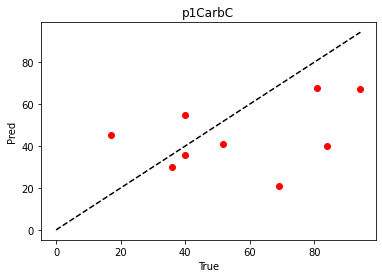

<Figure size 432x288 with 0 Axes>

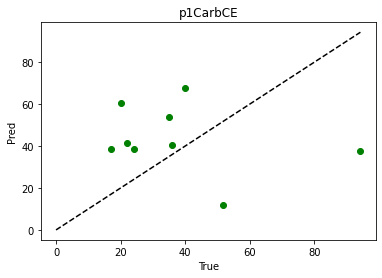

<Figure size 432x288 with 0 Axes>

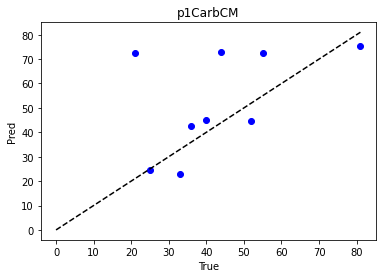

<Figure size 432x288 with 0 Axes>

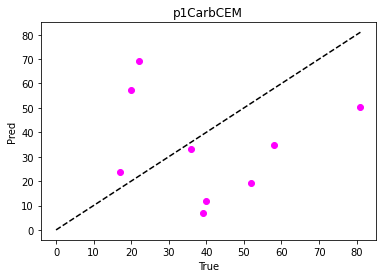

<Figure size 432x288 with 0 Axes>

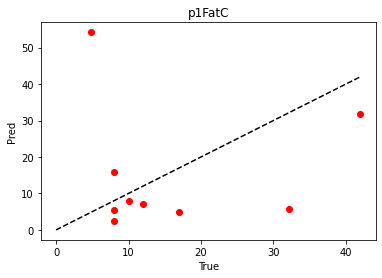

<Figure size 432x288 with 0 Axes>

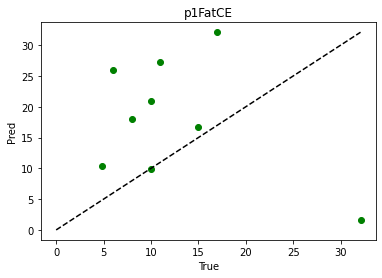

<Figure size 432x288 with 0 Axes>

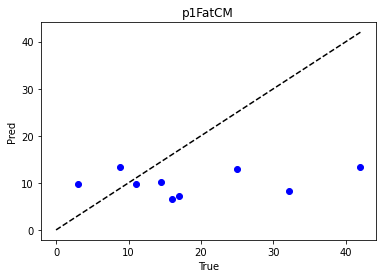

<Figure size 432x288 with 0 Axes>

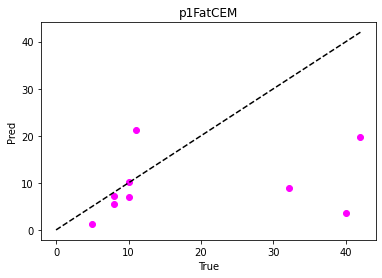

<Figure size 432x288 with 0 Axes>

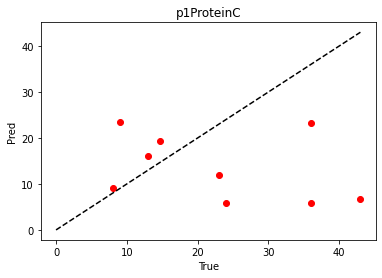

<Figure size 432x288 with 0 Axes>

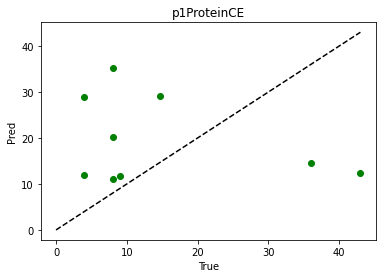

<Figure size 432x288 with 0 Axes>

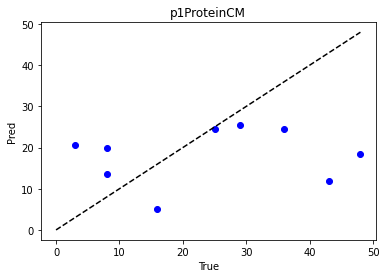

<Figure size 432x288 with 0 Axes>

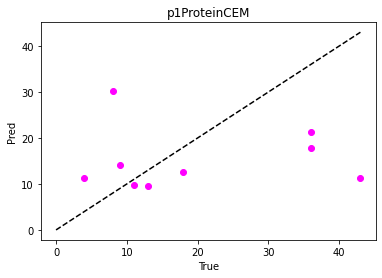

<Figure size 432x288 with 0 Axes>

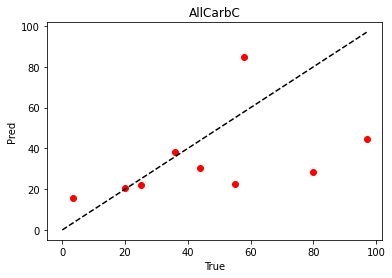

<Figure size 432x288 with 0 Axes>

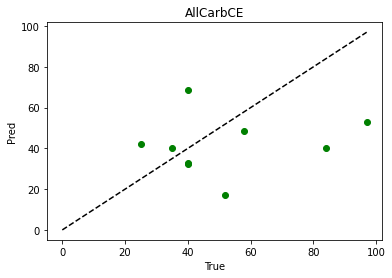

<Figure size 432x288 with 0 Axes>

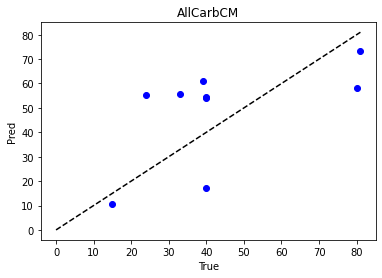

<Figure size 432x288 with 0 Axes>

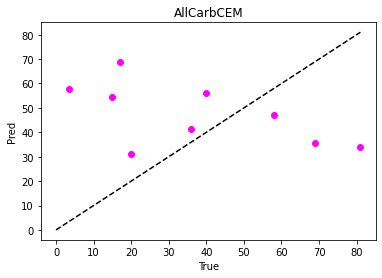

<Figure size 432x288 with 0 Axes>

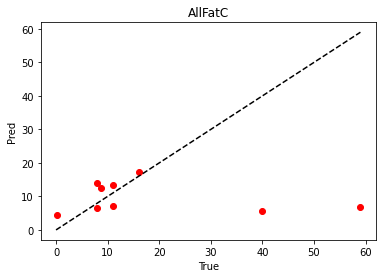

<Figure size 432x288 with 0 Axes>

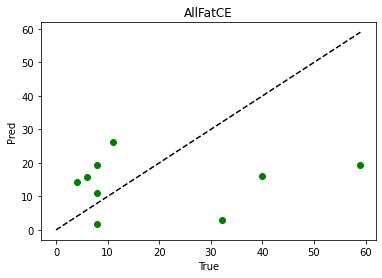

<Figure size 432x288 with 0 Axes>

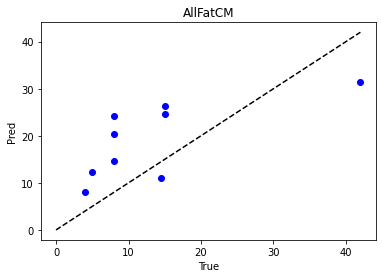

<Figure size 432x288 with 0 Axes>

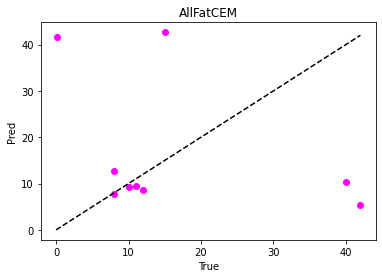

<Figure size 432x288 with 0 Axes>

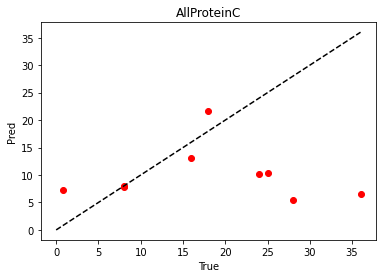

<Figure size 432x288 with 0 Axes>

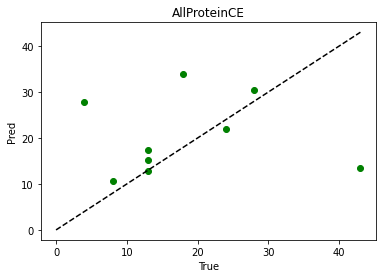

<Figure size 432x288 with 0 Axes>

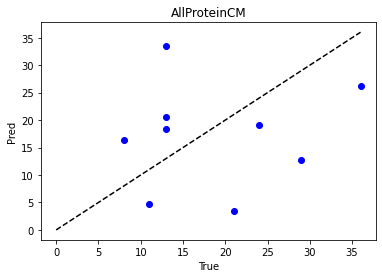

<Figure size 432x288 with 0 Axes>

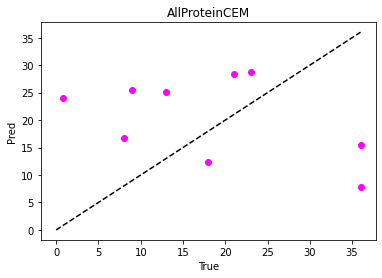

<Figure size 432x288 with 0 Axes>

In [ ]:
def stringFixer(df):
    dfColumns = ["TrueMacro", "PredictedMacro"]
    for dfColumn in dfColumns:
        for counter in range(len(df)):
            tempVal = df[dfColumn].iloc[counter]
            tempVal = tempVal.replace("[", "")
            tempVal = tempVal.replace("]", "")
            tempVal = list(tempVal.split(" "))
            tempVal = list(filter(None, tempVal))
            tempVal = np.asarray(tempVal).astype(float)
            df[dfColumn].iloc[counter] = tempVal
    return df


dfRegressor = pd.read_csv(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.csv")))
dfRegressor = stringFixer(dfRegressor)

dfRegressor.reset_index(drop=True, inplace=True)
dfRegressor.replace("CGM", "C", inplace=True)
dfRegressor.replace("CGM+F1+F2+F5", "CM", inplace=True)
dfRegressor.replace("CGM+BVP+EDA+HR+Temperature", "CE", inplace=True)
dfRegressor.replace("CGM+BVP+EDA+HR+Temperature+F1+F2+F5", "CEM", inplace=True)
components = ["Carb", "Fat", "Protein"]
colors = ["red", "green", "blue", "magenta"]
participants = list(set(dfRegressor["Participant"].to_list()))
combinations = list(set(dfRegressor["Combination"].to_list()))

dfPearson = []
for participant in participants:
    dfParticipant = dfRegressor[dfRegressor["Participant"] == participant]
    for component in components:
        dfComponent = dfParticipant[dfParticipant["Component"] == component]
        for counter in range(len(combinations)):
            myFig = plt.figure()
            dfCombination = dfComponent[dfComponent["Combination"] == combinations[counter]]
            trueVal = dfCombination["TrueMacro"].to_list()
            trueVal = np.asarray(trueVal).astype(float)
            trueVal = trueVal.flatten()

            predVal = dfCombination["PredictedMacro"].to_list()
            predVal = np.asarray(predVal).astype(float)
            predVal = predVal.flatten()

            figName = participant + component + combinations[counter]
            plt.scatter(x=trueVal, y=predVal, c=colors[counter])
            plt.title(figName)
            plt.plot([0, np.max(trueVal)], [0, np.max(trueVal)], "k--")
            tempVal = pearsonr(trueVal, predVal)[0]
            dfPearson.append([participant, component, combinations[counter], tempVal])
            plt.xlabel("True")
            plt.ylabel("Pred")
            plt.show()
            plt.savefig(os.path.join(addDataPrefix, "Results", figName + ".png"))
dfPearson = pd.DataFrame(dfPearson, columns=["Participant", "Component", "Combination", "Pearson"])
dfPearson.insert(len(dfPearson.columns), "RelativePearson", -100)
dfPearson["RelativePearson"] = dfPearson["Pearson"]
for participant in participants:  # Finding the difference of C with other Combinations
    for component in components:
        dfTemp = dfPearson[dfPearson["Participant"] == participant]
        dfTemp = dfTemp[dfTemp["Component"] == component]
        baseLine = dfTemp[dfTemp["Combination"] == "C"]
        baseLine = baseLine["RelativePearson"].sum()
        for counter in range(len(dfPearson)):
            if dfPearson["Participant"].iloc[counter] == participant and dfPearson["Component"].iloc[counter] == component:
                dfPearson["RelativePearson"].iloc[counter] -= baseLine
dfPearson.to_csv(os.path.join(addDataPrefix, "Results", "Pearson.csv"), index=False)



In [ ]:
# dfTrain=pd.read_csv('/home/grads/s/sorush.omidvar/STMI-CGM-Predictor/train.csv')
# dfTest=pd.read_csv('/home/grads/s/sorush.omidvar/STMI-CGM-Predictor/test.csv')
# dfVal=pd.read_csv('/home/grads/s/sorush.omidvar/STMI-CGM-Predictor/val.csv')

# trainData=dfTrain.to_numpy()
# testData=dfTest.to_numpy()
# valData=dfVal.to_numpy()

# xTrain=trainData[:,0:-4]
# xTest=testData[:,0:-4]
# xVal=valData[:,0:-4]
# print(xTrain.shape,xVal.shape,xVal.shape)

# for counter in range(3):
#     plt.figure()
#     yTrain=trainData[:,-4+counter]
#     yTest=testData[:,-4+counter]
#     yVal=valData[:,-4+counter]

#     # clf = xgb.XGBRegressor(n_jobs=24, objective="reg:squarederror")
#     # clf.fit(xTrain, yTrain)
#     # predictionsVal = clf.predict(xTest)
#     # plt.scatter(yTest,predictionsVal)
#     # plt.plot([0,100],[0,100],'--k')
#     rmseBest=1000000
#     for maxDepth in np.arange(2, 8, 1):
#         for estimator in np.arange(50, 200, 50):
#             clf = xgb.XGBRegressor(n_jobs=24,n_estimators=estimator, max_depth=maxDepth, objective="reg:squarederror")
#             clf.fit(xTrain, yTrain)
#             predictionsVal = clf.predict(xVal)
#             rmse = rmseCalculator(yVal, predictionsVal)
#             rmsle = rmsleCalculator(yVal, predictionsVal)
#             if rmse < rmseBest:
#                 rmseBest = rmse
#                 modelBest = clf
#                 bestDepth=maxDepth
#                 bestEstimator=estimator
#     predictionsTest = clf.predict(xTest)
#     plt.scatter(yTest,predictionsTest)
#     plt.plot([0,100],[0,100],'--k')



In [ ]:
# def stringFixer(df):
#     dfColumns = ["TrueMacro", "PredictedMacro"]
#     for dfColumn in dfColumns:
#         for counter in range(len(df)):
#             tempVal = df[dfColumn].iloc[counter]
#             tempVal = tempVal.replace("[", "")
#             tempVal = tempVal.replace("]", "")
#             tempVal = list(tempVal.split(" "))
#             tempVal = list(filter(None, tempVal))
#             tempVal = np.asarray(tempVal).astype(float)
#             df[dfColumn].iloc[counter] = tempVal
#     return df


# dfRegressor = pd.read_csv(os.path.join(addDataPrefix, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.csv")))
# dfRegressor = stringFixer(dfRegressor)

# dfRegressor.reset_index(drop=True, inplace=True)
# dfRegressor.replace("CGM", "C", inplace=True)
# dfRegressor.replace("CGM+F1+F2+F5", "CM", inplace=True)
# dfRegressor.replace("CGM+BVP+EDA+HR+Temperature", "CE", inplace=True)
# dfRegressor.replace("CGM+BVP+EDA+HR+Temperature+F1+F2+F5", "CEM", inplace=True)
# components = ["Carb", "Fat", "Protein"]
# colors = ["red", "green", "blue", "magenta"]
# participants = list(set(dfRegressor["Participant"].to_list()))
# combinations = list(set(dfRegressor["Combination"].to_list()))

# dfPearson = []
# for participant in participants:
#     dfParticipant = dfRegressor[dfRegressor["Participant"] == participant]
#     for component in components:
#         dfComponent = dfParticipant[dfParticipant["Component"] == component]
#         for counter in range(len(combinations)):
#             # myFig=plt.figure()
#             dfCombination = dfComponent[dfComponent["Combination"] == combinations[counter]]
#             trueVal = dfCombination["TrueMacro"].to_list()
#             trueVal = np.asarray(trueVal).astype(float)
#             trueVal = trueVal.flatten()

#             predVal = dfCombination["PredictedMacro"].to_list()
#             predVal = np.asarray(predVal).astype(float)
#             predVal = predVal.flatten()

#             plt.scatter(x=trueVal, y=predVal, c=colors[counter])
#             plt.title(participant + component + combinations[counter])
#             plt.plot([0, np.max(trueVal)], [0, np.max(trueVal)], "k--")
#             tempVal = pearsonr(trueVal, predVal)[0]
#             dfPearson.append([participant, component, combinations[counter], tempVal])
#             plt.xlabel("True")
#             plt.ylabel("Pred")
#             plt.show()
#             plt.savefig(pl)
# dfPearson = pd.DataFrame(dfPearson, columns=["Participant", "Component", "Combination", "Pearson"])
# dfPearson.insert(len(dfPearson.columns),"RelativePearson",-100)
# dfPearson["RelativePearson"]=dfPearson["Pearson"]
# for participant in participants:  # Finding the difference of C with other Combinations
#     for component in components:
#         dfTemp = dfPearson[dfPearson["Participant"] == participant]
#         dfTemp = dfTemp[dfTemp["Component"] == component]
#         baseLine = dfTemp[dfTemp["Combination"] == "C"]
#         baseLine = baseLine["RelativePearson"].sum()
#         for counter in range(len(dfPearson)):
#             if dfPearson["Participant"].iloc[counter] == participant and dfPearson["Component"].iloc[counter] == component:
#                 dfPearson["RelativePearson"].iloc[counter] -= baseLine
# dfPearson.to_csv(os.path.join(addDataPrefix, "Pearson.csv"), index=False)

